# Database Security Course Project (CS850)

Detecting XSS attacks using Deep Learning

In [1]:
#Importing all the dependencies.
import re
import os
import random
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from tensorflow.keras.layers import LSTM, Dense, Dropout, Embedding, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau

In [4]:
df=pd.read_csv("/content/drive/MyDrive/XSS_dataset.csv")

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
seed_value= 0

os.environ['PYTHONHASHSEED']=str(seed_value)

random.seed(seed_value)

np.random.seed(seed_value)

tf.random.set_seed(seed_value)

In [6]:
df.drop(df.columns[df.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)

In [7]:
df.head()

,Sentence,Label
0,"<li><a href=""/wiki/File:Socrates.png"" class=""i...",0
1,"<tt onmouseover=""alert(1)"">test</tt>",1
2,"\t </span> <span class=""reference-text"">Steeri...",0
3,"\t </span> <span class=""reference-text""><cite ...",0
4,"\t </span>. <a href=""/wiki/Digital_object_iden...",0


In [8]:
df['Label'].value_counts()

1    7373
0    6313
Name: Label, dtype: int64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13686 entries, 0 to 13685
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Sentence  13686 non-null  object
 1   Label     13686 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 214.0+ KB


In [10]:
SIZE = 100
BATCH_SIZE = 64
EPOCHS = 100

In [11]:
def convert_to_ascii(script):
    list = []
    for char in script:
        list.append(ord(char))
    vector = np.zeros((10000))
    for char in range(len(list)):
        vector[char] = list[char]
    vector.shape = (100,100)
    return vector

In [12]:
x = df["Sentence"].values
y = df["Label"]

In [13]:
arr=np.zeros((len(x),100,100))

for i in range(len(x)):
    image=convert_to_ascii(x[i])
    arr[i]=image

In [14]:
x = arr.reshape(arr.shape[0], 100, 100, 1)

In [15]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,shuffle='True',stratify=y)

In [16]:
model = Sequential()
model.add(Conv2D(64,(3,3), activation='relu', input_shape=(100,100,1)))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(128,(3,3), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(256,(3,3), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [17]:
es = EarlyStopping(monitor='val_loss',
        mode='min',
        patience=5,
        restore_best_weights=True,
        verbose=1)
mc = ModelCheckpoint('best_model.h5',verbose=1,save_best_only=True, save_weights_only = True)
reduce_lr=ReduceLROnPlateau( monitor="val_loss",factor=0.7,patience=5, verbose=1)
callbacks=[es,mc,reduce_lr]

In [18]:
model.compile(loss='binary_crossentropy',
                optimizer='adam',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2  (None, 49, 49, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 47, 47, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 23, 23, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 21, 21, 256)       295168    
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 10, 10, 256)       0

In [ ]:
history=model.fit(x_train,y_train,batch_size=BATCH_SIZE,epochs=EPOCHS,validation_data=(x_test, y_test),callbacks=[es,mc,reduce_lr])

Epoch 1/100
 74/172 [===========>..................] - ETA: 6:04 - loss: 0.4450 - accuracy: 0.7935

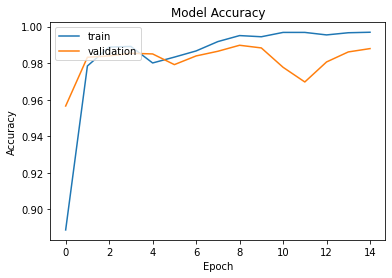

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
val_accuracy=max(history.history['val_accuracy'])
accuracy=max(history.history['accuracy'])
val_loss=min(history.history['val_loss'])
loss=min(history.history['loss'])
print(f'Test-Accuracy: {val_accuracy}')
print(f'Train-Accuracy: {accuracy}')
print(f'Test-loss: {val_loss}')
print(f'Train-loss: {loss}')

Test-Accuracy: 0.9897735714912415
Train-Accuracy: 0.9968944191932678
Test-loss: 0.04072319343686104
Train-loss: 0.008838384412229061


In [ ]:
pred=model.predict(x_test)